In [1]:
import torch
import utils 
import torch.nn as nn
import torch.optim as optim
import config
import torchvision as tv
from dataset import NuIDDataset 
from torch.utils.data import DataLoader
from training_utils_copy import *
import scipy.stats as stats
from sparceNetPID_copy import SparceNetPID
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
# Define discriminator and generator objects 
# model = SparceNetPID(
#     imageChannels = config.IMAGE_CHANNELS,
#     numClasses = config.N_CLASSES,
#     imageDimentions= config.INPUT_SIZE,
# )
model = tv.models.resnet18(pretrained=False)
input_size = model.fc.in_features
model.fc = torch.nn.Linear(input_size, out_features=config.N_CLASSES)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

/home/giorgio/miniconda3/envs/mphys/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/giorgio/miniconda3/envs/mphys/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
# Define optimiser for both discriminator and generator
optimiser = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, betas=config.MOMENTUM
)


# Loss function for model trianing 
criterion = torch.nn.CrossEntropyLoss().to(config.DEVICE)

# Load previously saved models and optimisers if True
if config.LOAD_MODEL:
    utils.load_checkpoint(
        config.CHECKPOINT_GEN_LOAD, model, optimiser, config.LEARNING_RATE,
    )



In [4]:
# Initialise training dataset and dataloader
train_dataset = NuIDDataset(
    "/home/giorgio/Desktop/train", 
    name = "train",
    maxVoxels=config.MAX_VOXELS, 
    maxParticles=config.MAX_PARTICLE,
    length=2000,
    imageDims=config.IMAGE_SIZE,
    nClasses=config.N_CLASSES,
)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
)

# Initialise validation dataset and dataloader
val_dataset = NuIDDataset(
    "/home/giorgio/Desktop/test", 
    name = "test",
    maxVoxels=config.MAX_VOXELS, 
    maxParticles=config.MAX_PARTICLE,
    length=1000,
    imageDims=config.IMAGE_SIZE,
    nClasses=config.N_CLASSES,
)
val_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
)

# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Grayscale(),
#     transforms.Normalize(mean=[.5], std=[.5]),
#     transforms.Pad(40)
# ])

# dataset_flag = "bloodmnist"
# download = True

# # Get dataclass attribute, ie: the location of the object containing desired data 
# info = INFO[dataset_flag]
# DataClass = getattr(medmnist, info["python_class"])

# # load the data (ie: member of torch.utils.data.DataClass)
# train_dataset = DataClass(split="train", download=download, transform=data_transform)
# train_loader = DataLoader(dataset=train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

# val_dataset = DataClass(split="test", download=download, transform=data_transform)
# val_loader = DataLoader(dataset=val_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

# define dictionary to hodl dataloaders
dataloaders = {"train":train_loader, "val":val_loader}
dataset_sizes = {"train":2000, "val":2000}

   [WARNING]  <trainData3d::configure> BatchFillerSparseTensor3D is only supported with one channel!
   [WARNING]  <testData3d::configure> BatchFillerSparseTensor3D is only supported with one channel!


In [5]:
# Train the model
model, statistic = train_model(model, config.NUM_EPOCHS, criterion, optimiser, dataloaders,dataset_sizes, config.DEVICE)

=== Train 1 ===
    Loss: 0.5157
    Accuracy: 0.7765
    F1: 0.3085
=== Val 1 ===
    Loss: 0.4834
    Accuracy: 0.7800
    F1: 0.3053

=== Train 2 ===
    Loss: 0.5024
    Accuracy: 0.7965
    F1: 0.3005
=== Val 2 ===
    Loss: 0.5069
    Accuracy: 0.7705
    F1: 0.3120

=== Train 3 ===
    Loss: 0.4330
    Accuracy: 0.8005
    F1: 0.3324
=== Val 3 ===
    Loss: 0.4485
    Accuracy: 0.7900
    F1: 0.3109

=== Train 4 ===
    Loss: 0.4068
    Accuracy: 0.8075
    F1: 0.3787
=== Val 4 ===
    Loss: 0.4383
    Accuracy: 0.7985
    F1: 0.3026

=== Train 5 ===
    Loss: 0.3989
    Accuracy: 0.7970
    F1: 0.4227
=== Val 5 ===
    Loss: 2.7615
    Accuracy: 0.7845
    F1: 0.2931

=== Train 6 ===
    Loss: 0.3811
    Accuracy: 0.8355
    F1: 0.4535
=== Val 6 ===
    Loss: 2.1181
    Accuracy: 0.7780
    F1: 0.2917

=== Train 7 ===
    Loss: 0.4055
    Accuracy: 0.8205
    F1: 0.4706
=== Val 7 ===
    Loss: 0.4267
    Accuracy: 0.7970
    F1: 0.3432

=== Train 8 ===
    Loss: 0.3758
    Accu

In [6]:
# Save the model if configured to do so
if config.SAVE_MODEL:
    utils.save_checkpoint(model, optimiser,)

==> Saving checkpoint


In [7]:
# Print some statistics
model = model.eval().to(config.DEVICE)
def get_confusion_matrix():
    global model, dataloaders
    confusion = np.zeros((config.N_CLASSES, config.N_CLASSES))
    binning = np.linspace(0, config.N_CLASSES, config.N_CLASSES+1, dtype=int)

    for (images, labels) in dataloaders['val']:
        images = images.type(torch.float32).to(config.DEVICE)
        labels = labels.type(torch.LongTensor).to(config.DEVICE)
        output = model(images,)
        _, preds = torch.max(output, 1)
        labels
        H, *_ = stats.binned_statistic_2d(labels.to('cpu').numpy().flatten(), preds.to('cpu').numpy().flatten(), None, bins=[binning, binning], statistic='count')
        confusion += H
    return confusion

In [8]:
confusion = get_confusion_matrix()
print(f"{confusion}")
class_name = {0: "nuMuCC", 1: "nuECC", 2: "NC",}
print("--- Class Accuracy")
for t in range(confusion.shape[0]):
    print(f"{list(class_name.keys())[t]:6}: {100*(confusion[t,t] / confusion[t].sum()):.1f}")
print()

[[   0.   11.    0.]
 [   0. 1561.    0.]
 [   0.  428.    0.]]
--- Class Accuracy
     0: 0.0
     1: 100.0
     2: 0.0



In [9]:
statistic

{'train': {'loss': [0.5157389782331884,
   0.5023932344503701,
   0.43304126271698623,
   0.40678430910781027,
   0.39890051071066407,
   0.3811143853343092,
   0.4055331546063535,
   0.37580349602503704,
   0.3784781113290228,
   0.3990343544976786],
  'accuracy': [0.7765,
   0.7965,
   0.8005,
   0.8075,
   0.797,
   0.8355,
   0.8205,
   0.825,
   0.826,
   0.817],
  'f1': [0.3085102727959871,
   0.3004991007288024,
   0.33242995273177506,
   0.3787457627955176,
   0.42265154441796104,
   0.4534607345476262,
   0.47056714459216487,
   0.46454816838106777,
   0.4637830911354224,
   0.47851531679873754]},
 'val': {'loss': [0.4833948374688625,
   0.5068583843726665,
   0.44845297913625837,
   0.43826354227168485,
   2.7615496964430126,
   2.11808090908665,
   0.4267010731468526,
   6.8992057027816776,
   10.382997670173644,
   13.795438903808593],
  'accuracy': [0.78,
   0.7705,
   0.79,
   0.7985,
   0.7845,
   0.778,
   0.797,
   0.7825,
   0.783,
   0.779],
  'f1': [0.30525879917184

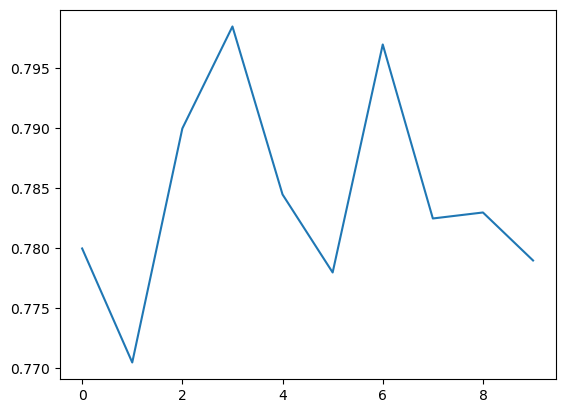

In [10]:
plt.plot(statistic["val"]["accuracy"])